# Chapter 11 Training Deep Neural Nets

# Setup

In [2]:
from __future__ import division, print_function, unicode_literals 

# common imports 
import numpy as np
import os

# to make this notebook's output stable across runs 
def reset_graph(seed=42): 
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed) 

# To plot nice figures 
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

import tensorflow as tf
from tensorflow.keras import layers

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z): 
    return 1/(1+np.exp(-z))

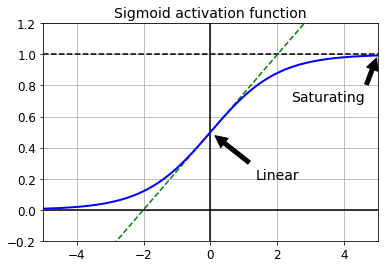

In [3]:
z = np.linspace(-5,5,200) 

plt.plot([-5,5],[0,0],'k-')
plt.plot([-5,5],[1,1],'k--')
plt.plot([0,0],[-0.2,1.2],'k-')
plt.plot([-5,5],[-3/4,7/4],'g--')
plt.plot(z,logit(z),'b-',linewidth=2)
props = dict(facecolor="black",shrink=0.1)
plt.annotate('Saturating',xytext=(3.5,0.7),xy=(5,1),arrowprops=props,fontsize=14,ha="center")
plt.annotate('Linear',xytext=(2,0.2),xy=(0,0.5),arrowprops = props,fontsize =14,ha="center")
plt.grid(True)
plt.title("Sigmoid activation function",fontsize=14)
plt.axis([-5,5,-0.2,1.2])
plt.show()

# Xavier and He Initialization

In [4]:
import tensorflow as tf

In [5]:
reset_graph() 
n_inputs = 28*28
n_hidden1=30

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1= tf.layers.dense(X,n_hidden1,activation=tf.nn.relu,
                        kernel_initializer=he_init,name="hidden1")

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


# Nonsaturating Activation Functions

In [7]:
def leaky_relu(z,alpha=0.01):
    return np.maximum(alpha*z,z)

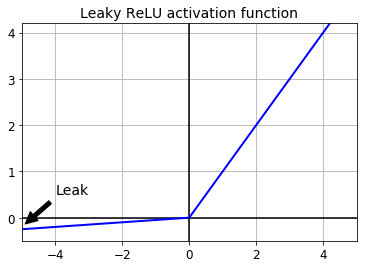

In [8]:
plt.plot([-5,5],[0,0],'k-')
plt.plot([0,0],[-0.5,4.2],'k-')
plt.plot(z,leaky_relu(z,0.05),"b-",linewidth=2)
plt.grid(True)
props = dict(facecolor='black',shrink=0.1)
plt.annotate('Leak',xytext=(-3.5,0.5),xy=(-5,-0.2),arrowprops=props,fontsize=14,ha='center')
plt.title("Leaky ReLU activation function",fontsize=14)
plt.axis([-5,5,-0.5,4.2])
plt.show()

Implementing Leaky ReLU in Tensorflow

In [ ]:
reset_graph() 
X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")

In [ ]:
def leaky_relu(z,name=None): 
    return tf.maximum(0.01*z,z,name=name)
# hidden1=tf.layers.dense(X,n_hidden1,activation=leaky_relu,name="hidden1")

Let's train a neural network on MNIST using Leaky ReLU

In [ ]:

reset_graph()

n_inputs = 28*28 
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10


In [ ]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [ ]:
with tf.name_scope("dnn"): 
    hidden1 = tf.layers.dense(X,n_hidden1,activation=leaky_relu,name="hidden1")
    hidden2 = tf.layers.dense(hidden1,n_hidden2,activation=leaky_relu,name="hidden2")
    logits  = tf.layers.dense(hidden2,n_outputs,name="outputs")

In [ ]:
with tf.name_scope("loss"): 
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")

In [ ]:
learning_rate = 0.1

with tf.name_scope("train"): 
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
    traing_op = optimizer.minimize(loss) 

In [ ]:
with tf.name_scope("eval"):
    correct  = tf.nn.in_top_k(logits,y,1) 
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32)) 

In [ ]:
init = tf.global_variables_initializer() 
saver = tf.train.Saver()

Load the data: 

In [10]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data() 
X_train = X_train.astype(np.float32).reshape(-1,28*28)/255.0
X_test  = X_test.astype(np.float32).reshape(-1,28*28)/255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32) 
X_valid,X_train = X_train[:5000],X_train[5000:]
y_valid,y_train = y_train[:5000],y_train[5000:]

In [11]:
def shuffle_batch(X,y,batch_size): 
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx,n_batches):
        X_batch,y_batch=X[batch_idx],y[batch_idx]
        yield X_batch,y_batch

In [ ]:
n_epochs =40 
batch_size = 50

with tf.Session() as sess: 
    init.run() 
    for epoch in range(n_epochs): 
        for X_batch, y_batch in shuffle_batch(X_train,y_train,batch_size): 
            sess.run(traing_op,feed_dict = {X:X_batch,y:y_batch})
        if epoch%5 ==0: 
            acc_batch = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
            acc_valid = accuracy.eval(feed_dict={X:X_valid,y:y_valid})
            print(epoch,"Batch accuracy:",acc_batch,"Validation accuracy:",acc_valid)
    save_path = saver.save(sess,"./my_model_final.ckpt")

# Batch Normalization

In [3]:

reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [4]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')


In [5]:

from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.


In [7]:

reset_graph()

learning_rate = 0.1
batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [8]:

n_epochs = 20
batch_size = 200

In [12]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9522
1 Validation accuracy: 0.9682
2 Validation accuracy: 0.9634
3 Validation accuracy: 0.9738
4 Validation accuracy: 0.9752
5 Validation accuracy: 0.9784
6 Validation accuracy: 0.9782
7 Validation accuracy: 0.9786
8 Validation accuracy: 0.9804
9 Validation accuracy: 0.9818
10 Validation accuracy: 0.9784
11 Validation accuracy: 0.9816
12 Validation accuracy: 0.9806
13 Validation accuracy: 0.9808
14 Validation accuracy: 0.982
15 Validation accuracy: 0.9822
16 Validation accuracy: 0.982
17 Validation accuracy: 0.9812
18 Validation accuracy: 0.9802
19 Validation accuracy: 0.9826


In [13]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [14]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

# Gradient Clipping
Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier, except that we added a few more additional layers to demonstrate reusing pretrained models. 

In [15]:
reset_graph() 

n_inputs = 28*28 
n_hidden1 = 300 
n_hidden2 = 50 
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10 

X = tf.placeholder(tf.float32, shape=(None,n_inputs),name="X") 
y = tf.placeholder(tf.int32,shape=(None),name = "y") 

with tf.name_scope("dnn"): 
    hidden1 = tf.layers.dense(X,n_hidden1,activation=tf.nn.relu,name="hidden1")
    hidden2 = tf.layers.dense(hidden1,n_hidden2,activation=tf.nn.relu,name="hidden2")
    hidden3 = tf.layers.dense(hidden2,n_hidden3,activation=tf.nn.relu,name="hidden3")
    hidden4 = tf.layers.dense(hidden3,n_hidden4,activation=tf.nn.relu,name="hidden4")
    hidden5 = tf.layers.dense(hidden4,n_hidden5,activation=tf.nn.relu,name="hidden5")
    logits  = tf.layers.dense(hidden5,n_outputs,name = "outputs")
    
with tf.name_scope("loss"): 
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")

In [16]:
learning_rate = 0.01 

Now we apply gradient clipping. 

In [20]:
threshold = 1.0 

optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
grads_and_vars = optimizer.compute_gradients(loss) 
capped_gvs = [(tf.clip_by_value(grad,-threshold,threshold),var) 
              for grad,var in grads_and_vars] 
training_op = optimizer.apply_gradients(capped_gvs) 

In [21]:
with tf.name_scope("eval"): 
    correct = tf.nn.in_top_k(logits,y,1) 
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name="accuracy")

In [22]:
init = tf.global_variables_initializer() 
saver = tf.train.Saver() 

In [23]:
n_epochs = 20 
batch_size = 200 

In [24]:
with tf.Session() as sess: 
    init.run() 
    for epoch in range(n_epochs): 
        for X_batch,y_batch in shuffle_batch(X_train,y_train,batch_size): 
            sess.run(training_op,feed_dict = {X:X_batch,y:y_batch})
            
        accuracy_val = accuracy.eval(feed_dict={X:X_valid,y:y_valid})
        print(epoch,"Validation accuracy:",accuracy_val) 
    
    save_path = saver.save(sess,"./my_model_final.ckpt") 

0 Validation accuracy: 0.2876
1 Validation accuracy: 0.7944
2 Validation accuracy: 0.8796
3 Validation accuracy: 0.9058
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9356
8 Validation accuracy: 0.9378
9 Validation accuracy: 0.9416
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.947
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9532
14 Validation accuracy: 0.9564
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9614


# Reusing Pretrained Layers 
## Reusing a TensorFlow Model 

First, load the graph's structure. The import_meta_graph() function does just that. Note that by default, a Saver saves the structure of the graph into a .meta file. so that the file you should load: 

In [25]:
reset_graph() 

In [26]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta") 

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations: 

In [27]:
for op in tf.get_default_graph().get_operations(): 
    print(op.name) 

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

That's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph with Jupyter. 

In [29]:
from tensorflow_graph_in_jupyter import show_graph

ModuleNotFoundError: No module named 'tensorflow_graph_in_jupyter'

We can get a handle on operations to use that. 

In [30]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

We can create a collection containing all the important operations that people will want to get a handle on: 

In [31]:
for op in (X,y,accuracy,training_op): 
    tf.add_to_collection("my_important_ops",op)

In [32]:
X,y,accuracy,training_op = tf.get_collection("my_important_ops")

In [33]:
with tf.Session() as sess: 
    saver.restore(sess,"./my_model_final.ckpt") 
    
    for epoch in range(n_epochs): 
        for X_batch,y_batch in shuffle_batch(X_train,y_train,batch_size):
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid,y:y_valid})
        print(epoch,"Validation accuracy:",accuracy_val)
    
    save_path = saver.save(sess,"./my_new_model_final.ckpt") 

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.964
1 Validation accuracy: 0.9628
2 Validation accuracy: 0.9652
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9644
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9684
8 Validation accuracy: 0.9684
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9706
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9722
16 Validation accuracy: 0.972
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.971


## Freezing the Lower Layers

In [39]:
reset_graph() 

n_inputs = 28*28
n_hidden1 = 300 
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
y = tf.placeholder(tf.int32,shape=(None),name="y")

with tf.name_scope("dnn"): 
    hidden1 = tf.layers.dense(X,n_hidden1,activation=tf.nn.relu,name="hidden1")
    hidden2 = tf.layers.dense(hidden1,n_hidden2,activation=tf.nn.relu,name="hidden2")
    hidden3 = tf.layers.dense(hidden2,n_hidden3,activation=tf.nn.relu,name="hidden3")
    hidden4 = tf.layers.dense(hidden3,n_hidden4,activation=tf.nn.relu,name="hidden4")
    logits = tf.layers.dense(hidden4,n_outputs,name="outputs")
    
with tf.name_scope("loss"): 
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")

with tf.name_scope("eval"): 
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name="accuracy")

In [41]:
with tf.name_scope("train"): 
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # the following section shows how to freeze certain layers in training
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss,var_list=train_vars) 

In [44]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope = "hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # save the variable i want to reuse
init = tf.global_variables_initializer() 
saver = tf.train.Saver() 

with tf.Session() as sess: 
    init.run() 
    # restore lower layers from prev graph. 
    restore_saver.restore(sess,"./my_model_final.ckpt") 
    
    for epoch in range(n_epochs): 
        for X_batch,y_batch in shuffle_batch(X_train,y_train,batch_size): 
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid,y:y_valid})
        print(epoch,"Validation accuracy:",accuracy_val)

    save_path = saver.save(sess,"./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.896
1 Validation accuracy: 0.9298
2 Validation accuracy: 0.9396
3 Validation accuracy: 0.9442
4 Validation accuracy: 0.9482
5 Validation accuracy: 0.9506
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9536
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.9564
10 Validation accuracy: 0.956
11 Validation accuracy: 0.957
12 Validation accuracy: 0.9566
13 Validation accuracy: 0.9576
14 Validation accuracy: 0.9594
15 Validation accuracy: 0.9578
16 Validation accuracy: 0.9576
17 Validation accuracy: 0.9598
18 Validation accuracy: 0.9588
19 Validation accuracy: 0.9604


Another option is that we can add `stop_gradient()` before certain layers. 

In [67]:
reset_graph() 

In [68]:
n_inputs = 28*28
n_hidden1 = 300 
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 20
n_outputs = 10

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X") 
y = tf.placeholder(tf.int32,shape=(None),name="y") 


In [69]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!
    

In [70]:
with tf.name_scope("loss"): 
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")

with tf.name_scope("eval"): 
    correct = tf.nn.in_top_k(logits,y,1) 
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32),name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) 
    training_op = optimizer.minimize(loss) 



In [71]:
# Get value for the first few layers from graph file
reuse_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                              scope = "hidden[123]")
restore_saver = tf.train.Saver(reuse_vars) 

init = tf.global_variables_initializer() 
saver = tf.train.Saver() 

with tf.Session() as sess: 
    init.run() 
    restore_saver.restore(sess,"./my_model_final.ckpt") 
    
    for epoch in range(n_epochs): 
        for X_batch,y_batch in shuffle_batch(X_train,y_train,batch_size): 
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_valid,y:y_valid}) 
        print(epoch,"Validation accuracy:", accuracy_val) 
    
    save_path = saver.save(sess,"./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9022
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.943
3 Validation accuracy: 0.9476
4 Validation accuracy: 0.9512
5 Validation accuracy: 0.9524
6 Validation accuracy: 0.9522
7 Validation accuracy: 0.956
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.9562
10 Validation accuracy: 0.9572
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.958
14 Validation accuracy: 0.9584
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9584
